# COMPUTER VISION AND PATTERN RECOGNITION PROJECT
## Alessandro Cesa

In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import copy

In [ ]:
!wget -c https://github.com/AlessandroCesaTs/Computer_Vision_Project_Cesa/archive/main.zip
!unzip main.zip

In [3]:
train_path = "Computer_Vision_Project_Cesa-main/CVPR2023_project_2_and_3_data/train"
test_path = "Computer_Vision_Project_Cesa-main/CVPR2023_project_2_and_3_data/test"

In [28]:
transform=transforms.Compose([transforms.Resize((64,64)),transforms.ToTensor(),transforms.Grayscale()])

In [58]:
train=ImageFolder(root=train_path,transform=transform)
test=ImageFolder(root=test_path,transform=transform)

In [59]:
# check the dataset size
print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")
print(train.classes)

Train size: 1500
Test size: 2985
['Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial', 'InsideCity', 'Kitchen', 'LivingRoom', 'Mountain', 'Office', 'OpenCountry', 'Store', 'Street', 'Suburb', 'TallBuilding']


label: 0
class: Bedroom


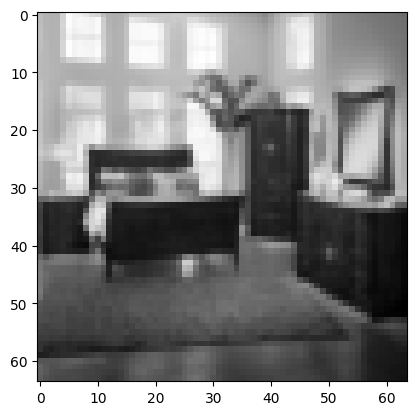

In [60]:
# get image no. 1 and its label
index=1
img,label=train[index]

print(f"label: {label}")

print("class: " + train.classes[label])
# display
figure = plt.figure()
plt.imshow(img.numpy().transpose((1, 2, 0)),cmap='gray') #<< swap axes because img is (3,H,W) but imshow() expects (H,W,3)

In [61]:
#split training set into training and validation
train_size=int(0.85*len(train))
validation_size=len(train)-train_size
training_set,validation_set=torch.utils.data.random_split(train,[train_size,validation_size])

In [62]:
# Create data loaders.
# Data loaders are basically objects that make easy to iterate through the data by batches of some batch_size

batch_size = 32
train_loader = DataLoader(training_set, batch_size=batch_size,shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size,shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size,shuffle=False)

for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# get a batch from the training set
dataiter = iter(train_loader)
images, labels = next(dataiter)   #images is a (batch_size,3,32,32) tensor

print(images.size())

Shape of X [N, C, H, W]: torch.Size([32, 1, 64, 64])
Shape of y: torch.Size([32]) torch.int64
torch.Size([32, 1, 64, 64])


torch.Size([32, 1, 64, 64])
Store LivingRoom LivingRoom OpenCountry Bedroom Coast InsideCity Kitchen Coast Coast Mountain Street Highway Coast Industrial Industrial LivingRoom Bedroom Kitchen Bedroom Kitchen TallBuilding OpenCountry LivingRoom Store Industrial Forest Store Mountain Industrial Forest Industrial


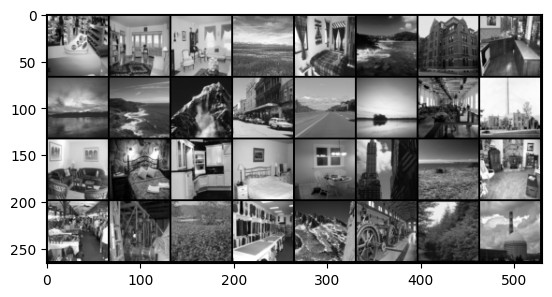

In [63]:
classes=train.classes

# get a batch from the training set
dataiter = iter(train_loader)
images, labels = next(dataiter)   #images is a (batch_size,3,32,32) tensor

print(images.size())

img=torchvision.utils.make_grid(images)
figure = plt.figure()
plt.imshow(img.numpy().transpose((1, 2, 0)),cmap='gray') #<< swap axes because img is (3,H,W) but imshow() expects (H,W,3)

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Industrial


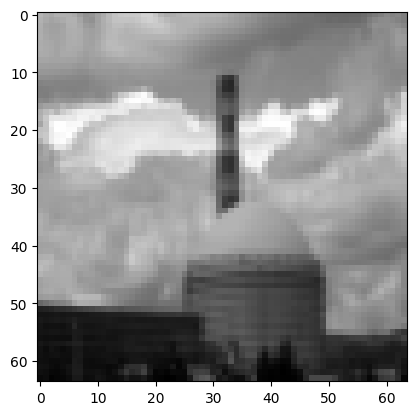

In [64]:
# display the last image only
figure = plt.figure()
plt.imshow(images[-1,:,:,:].numpy().transpose((1,2,0)),cmap='gray')
print(f'{train.classes[labels[-1]]:5s}')


In [65]:
#build the network

class simpleCNN(nn.Module):
  def __init__(self):
    super(simpleCNN,self).__init__() #initialize the model

    self.conv1=nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=1)
    self.relu1=nn.ReLU()
    self.maxpool1=nn.MaxPool2d(kernel_size=2,stride=2)

    self.conv2=nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1)
    self.relu2=nn.ReLU()
    self.maxpool2=nn.MaxPool2d(kernel_size=2,stride=2)

    self.conv3=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1)
    self.relu3=nn.ReLU()

    self.fc1=nn.Linear(16*16*16,15) #16 channels * 16*16 image (64*64 with 2 maxpooling of stride 2), 15 output features=15 classes
    self.softmax = nn.Softmax()
    self.output=nn.Linear(15,15)

  def forward(self,x):
    x=self.conv1(x)
    x=self.relu1(x)
    x=self.maxpool1(x)

    x=self.conv2(x)
    x=self.relu2(x)
    x=self.maxpool2(x)

    x=self.conv3(x)
    x=self.relu3(x)

    x=x.view(-1,16*16*16)

    x=self.fc1(x)
    x=self.softmax(x)
    x=self.output(x)

    return x



In [66]:
def init_weights(m):
  if isinstance(m,nn.Conv2d) or isinstance(m,nn.Linear):
    nn.init.normal_(m.weight,0,0.01)
    nn.init.zeros_(m.bias)

In [67]:
# Instantiate the model
model = simpleCNN()

model.apply(init_weights)
# Print the model summary
print(model)


simpleCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (fc1): Linear(in_features=4096, out_features=15, bias=True)
  (softmax): Softmax(dim=None)
  (output): Linear(in_features=15, out_features=15, bias=True)
)


In [68]:
#Training

loss_function=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.01,momentum=0.9)

def train_one_epoch(epoch_index,loader):
  running_loss=0

  for i, data in enumerate(loader):

    inputs,labels=data #get the minibatch
    outputs=model(inputs) #forward pass

    loss=loss_function(outputs,labels) #compute loss
    running_loss+=loss.item() #sum up the loss for the minibatches processed so far

    optimizer.zero_grad() #reset gradients
    loss.backward() #compute gradient
    optimizer.step() #update weights

  return running_loss/(i+1) # average loss per minibatch


In [69]:
EPOCHS=5

best_validation_loss=np.inf

for epoch in range(EPOCHS):
  print('EPOCH{}:'.format(epoch+1))

  model.train(True)
  train_loss=train_one_epoch(epoch,train_loader)

  running_validation_loss=0.0

  model.eval()

  with torch.no_grad(): # Disable gradient computation and reduce memory consumption
    for i,vdata in enumerate(validation_loader):
      vinputs,vlabels=vdata
      voutputs=model(vinputs)
      vloss=loss_function(voutputs,vlabels)
      running_validation_loss+=vloss
  validation_loss=running_validation_loss/(i+1)
  print('LOSS train{} validation{}'.format(train_loss,validation_loss))


  if validation_loss<best_validation_loss: #save the model if it's the best so far
    timestamp=datetime.now().strftime('%Y%m%d_%H%M%S')
    best_validation_loss=validation_loss
    model_path='model_{}_{}'.format(timestamp,epoch)
    torch.save(model.state_dict(),model_path)


#load the best model and evaluate performance on the test set

newModel=simpleCNN()
newModel.load_state_dict(torch.load(model_path))

correct=0
total=0

with torch.no_grad():
  for data in test_loader:
    images,labels=data
    outputs=newModel(images)
    _,predicted=torch.max(outputs.data,1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum().item()

print(f"Accuracy of the network on the test images: {100*correct/total}%")

EPOCH1:


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


ValueError: ignored